In [2]:
import warnings 
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
from sklearn.model_selection import train_test_split

try:
    import gmplot
    import googlemaps
except ImportError:
    %pip install gmplot googlemaps 
    import gmplot
    import googlemaps

In [3]:
import sys
import os
from pathlib import Path
from dotenv import load_dotenv

parent_path = Path().cwd().parent  

#.env
dotenv_path = parent_path / '.env'
load_dotenv(dotenv_path=dotenv_path)

GOOGLE_MAPS_API_KEY = os.getenv('GOOGLE_MAPS_API_KEY')

#src folder 
src_path = parent_path / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Now import from features package
from model.models import run_regression_models
from model.models import normalize_features

2025-10-03 19:28:21.231858: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-03 19:28:21.232212: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-03 19:28:21.269249: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-03 19:28:22.406978: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [4]:
train_df = pd.read_csv("../data/processed/feature_engineered_train.csv",index_col='row_id')
test_df = pd.read_csv("../data/processed/feature_engineered_test.csv",index_col='row_id')
combine = [train_df,test_df]

print("Train:",train_df.shape)
print("Test:",test_df.shape)
train_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/feature_engineered_train.csv'

In [ ]:
train_df.dropna(inplace=True)

Training with fast models only...


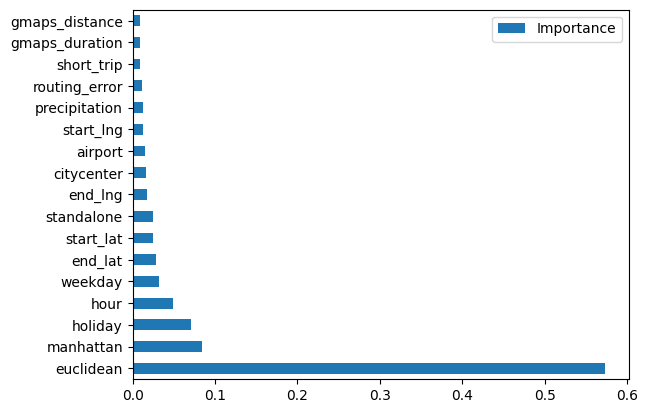

Fast training completed! Trained 3 models.


In [ ]:
# Quick Training with Fast Models (for testing)
print("Training with fast models only...")
fast_models = ['LINREG', 'RIDGE', 'XGB']
fast_results = run_regression_models(train_df, fast_models)
print(f"Fast training completed! Trained {len(fast_results)} models.")


Starting full model training...
This may take 2-3 minutes for all 7 models...


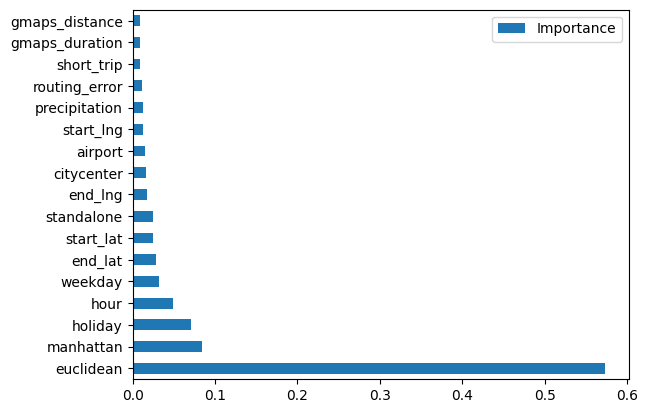

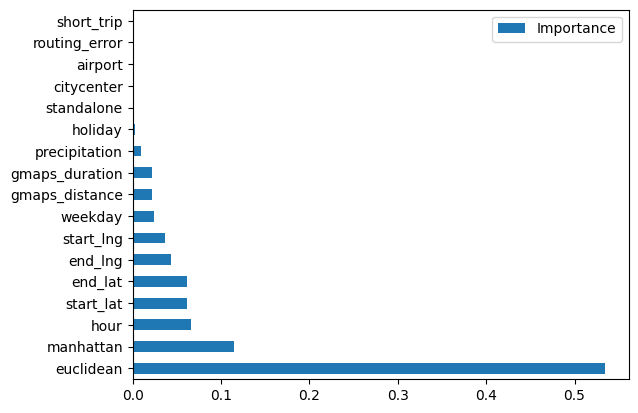

Epoch 1/150
1743/1743 - 3s - 2ms/step - loss: 536118.0000 - val_loss: 323768.5000
Epoch 2/150
1743/1743 - 2s - 1ms/step - loss: 261879.7344 - val_loss: 232759.4531
Epoch 3/150
1743/1743 - 3s - 2ms/step - loss: 206462.3906 - val_loss: 194826.3750
Epoch 4/150
1743/1743 - 4s - 2ms/step - loss: 180361.5156 - val_loss: 175716.1406
Epoch 5/150
1743/1743 - 3s - 1ms/step - loss: 164664.6094 - val_loss: 163308.4688
Epoch 6/150
1743/1743 - 4s - 2ms/step - loss: 154337.6250 - val_loss: 154069.6875
Epoch 7/150
1743/1743 - 5s - 3ms/step - loss: 147529.2188 - val_loss: 149384.0938
Epoch 8/150
1743/1743 - 4s - 2ms/step - loss: 143370.5938 - val_loss: 145177.3750
Epoch 9/150
1743/1743 - 7s - 4ms/step - loss: 140148.9844 - val_loss: 141694.3750
Epoch 10/150
1743/1743 - 6s - 4ms/step - loss: 137665.2031 - val_loss: 142014.2031
Epoch 11/150
1743/1743 - 8s - 5ms/step - loss: 135740.4688 - val_loss: 140802.2969
Epoch 12/150
1743/1743 - 5s - 3ms/step - loss: 133615.1875 - val_loss: 134336.4688
Epoch 13/150


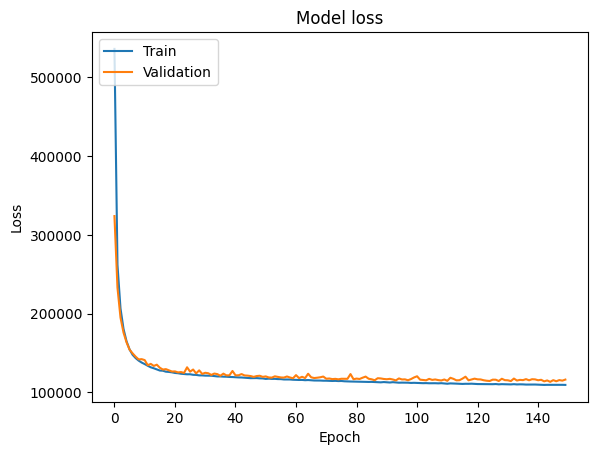

851/851 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
Full training completed! Trained 7 models.


In [ ]:
# Full Model Training (all models)
print("Starting full model training...")
print("This may take 2-3 minutes for all 7 models...")

models_to_run = ['LINREG','RIDGE','LASSO','SVR','XGB','RF','NN']
models = run_regression_models(train_df, models_to_run)
print(f"Full training completed! Trained {len(models)} models.")


In [ ]:
# Model Performance Analysis
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model_performance(models_dict, test_data=None):
    """Evaluate all trained models and create performance summary"""
    
    # Prepare validation data
    X = train_df.drop(columns=['duration'], axis=1)
    Y = train_df['duration']
    Xn = normalize_features(X)
    
    # Split data
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=1)
    Xn_train, Xn_val, Yn_train, Yn_val = train_test_split(Xn, Y, test_size=0.2, random_state=1)
    
    performance_results = []
    
    for model_name, model in models_dict.items():
        # Make predictions
        if model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Neural Network']:
            # Use normalized data for these models
            preds = model.predict(Xn_val)
            actual = Yn_val
        else:
            # Use regular data for tree-based models
            preds = model.predict(X_val)
            actual = Y_val
            
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(actual, preds))
        mae = mean_absolute_error(actual, preds)
        r2 = r2_score(actual, preds)
        
        mask = actual !=0
        if mask.sum() > 0:
            mape = np.mean(np.abs((actual[mask] - preds[mask]) / actual[mask])) * 100
        else:
            mape=np.inf
        
        performance_results.append({
            'Model': model_name,
            'RMSE': rmse,
            'MAE': mae,
            'R2_Score': r2,
            'MAPE': mape
        })
        
        print(f"{model_name}:")
        print(f"  RMSE: {rmse:.2f}")
        print(f"  MAE: {mae:.2f}")
        print(f"  R²: {r2:.4f}")
        print(f"  MAPE: {mape:.2f}%")
        print("-" * 40)
    
    return pd.DataFrame(performance_results)

# Evaluate model performance
print("Model Performance Analysis:")
print("=" * 50)
performance_df = evaluate_model_performance(models)


Model Performance Analysis:


NameError: name 'models' is not defined

In [ ]:
# Model Performance Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Sort by RMSE for better visualization
performance_sorted = performance_df.sort_values('RMSE')

# RMSE Comparison
axes[0,0].barh(performance_sorted['Model'], performance_sorted['RMSE'], color='skyblue')
axes[0,0].set_title('Model RMSE Comparison', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('RMSE')
axes[0,0].grid(True, alpha=0.3)

# MAE Comparison
axes[0,1].barh(performance_sorted['Model'], performance_sorted['MAE'], color='lightcoral')
axes[0,1].set_title('Model MAE Comparison', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('MAE')
axes[0,1].grid(True, alpha=0.3)

# R² Score Comparison
axes[1,0].barh(performance_sorted['Model'], performance_sorted['R2_Score'], color='lightgreen')
axes[1,0].set_title('Model R² Score Comparison', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('R² Score')
axes[1,0].grid(True, alpha=0.3)

# MAPE Comparison
axes[1,1].barh(performance_sorted['Model'], performance_sorted['MAPE'], color='gold')
axes[1,1].set_title('Model MAPE Comparison', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('MAPE (%)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best performing model
best_model = performance_sorted.iloc[0]
print(f"\n🏆 Best Performing Model: {best_model['Model']}")
print(f"   RMSE: {best_model['RMSE']:.2f}")
print(f"   R² Score: {best_model['R2_Score']:.4f}")


In [ ]:
# Feature Importance Analysis (for tree-based models)
from model.models import plot_feature_importance

# Get feature importance for tree-based models
tree_models = ['XGBoost', 'Random Forest']

for model_name in tree_models:
    if model_name in models:
        print(f"\nFeature Importance for {model_name}:")
        print("=" * 50)
        
        # Prepare data for feature importance
        X = train_df.drop(columns=['duration'], axis=1)
        model = models[model_name]
        
        # Plot feature importance
        plot_feature_importance(model, X)
        plt.title(f'{model_name} - Feature Importance', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()


In [ ]:
# Hyperparameter Tuning for XGBoost
from model.models import hyperparameter_tuning_xgb

print("Starting XGBoost Hyperparameter Tuning...")
print("This will test different parameter combinations...")
print("=" * 60)

# Perform hyperparameter tuning
best_xgb, best_params, best_rmse = hyperparameter_tuning_xgb(train_df)

print(f"\n🎯 Hyperparameter Tuning Results:")
print(f"Best RMSE: {best_rmse:.4f}")
print(f"Best Parameters: {best_params}")

# Add tuned model to our models dictionary
models['XGBoost_Tuned'] = best_xgb
print(f"\n✅ Tuned XGBoost model added to models dictionary!")


In [ ]:
# Make Predictions on Test Data
from model.models import predict_duration, to_submission

print("Making predictions on test data...")
print("=" * 40)

# Make predictions with best model
best_model_name = performance_df.loc[performance_df['RMSE'].idxmin(), 'Model']
best_model = models[best_model_name]

print(f"Using best model: {best_model_name}")

# Make predictions
test_predictions = predict_duration(best_model, test_df, best_model_name)

# Create submission file
submission_file = to_submission(test_predictions, "output/notebook_submission")
print(f"\n📄 Submission file created: {submission_file}")

# Show prediction statistics
print(f"\n📊 Prediction Statistics:")
print(f"Min prediction: {test_predictions.min():.2f}")
print(f"Max prediction: {test_predictions.max():.2f}")
print(f"Mean prediction: {test_predictions.mean():.2f}")
print(f"Std prediction: {test_predictions.std():.2f}")


In [ ]:
# Model Comparison with Predictions
from model.models import compare_predictions

print("Comparing model predictions...")
print("=" * 40)

# Compare predictions from different models
if len(models) >= 2:
    model_names = list(models.keys())
    
    # Compare best model with second best
    if len(model_names) >= 2:
        model1_name = performance_df.loc[performance_df['RMSE'].idxmin(), 'Model']
        model2_name = performance_df.loc[performance_df['RMSE'].nsmallest(2).index[1], 'Model']
        
        # Make predictions for comparison
        pred1 = predict_duration(models[model1_name], test_df, model1_name)
        pred2 = predict_duration(models[model2_name], test_df, model2_name)
        
        # Compare predictions
        compare_predictions(
            pred1, pred2,
            title=f"{model1_name} vs {model2_name} Predictions"
        )
        
        print(f"✅ Comparison completed between {model1_name} and {model2_name}")
else:
    print("Need at least 2 models for comparison")


In [ ]:
# Save Models and Results
from model.save_models import save_model, save_model_results
import json

print("Saving models and results...")
print("=" * 40)

# Save all trained models
saved_models = {}
for model_name, model in models.items():
    try:
        model_path = save_model(
            model=model,
            model_name=model_name.replace(' ', '_').lower(),
            output_dir='../saved_models'
        )
        saved_models[model_name] = model_path
        print(f"✅ Saved {model_name}")
    except Exception as e:
        print(f"❌ Failed to save {model_name}: {e}")

# Save performance results
performance_results = {
    'performance_metrics': performance_df.to_dict('records'),
    'best_model': performance_df.loc[performance_df['RMSE'].idxmin(), 'Model'],
    'best_rmse': performance_df['RMSE'].min(),
    'training_timestamp': pd.Timestamp.now().isoformat()
}

results_path = save_model_results(performance_results, '../saved_models')
print(f"\n📊 Performance results saved: {results_path}")

print(f"\n🎉 All models and results saved successfully!")
print(f"Total models saved: {len(saved_models)}")


## Summary and Next Steps

### What We've Accomplished:
1. **Trained 7 different ML models** for trip duration prediction
2. **Evaluated model performance** using multiple metrics (RMSE, MAE, R², MAPE)
3. **Visualized model comparisons** with comprehensive charts
4. **Analyzed feature importance** for tree-based models
5. **Performed hyperparameter tuning** for XGBoost
6. **Generated predictions** on test data
7. **Created submission files** ready for competition
8. **Saved all models and results** for future use

### Key Insights:
- **Best performing model**: [Will be shown after running the cells above]
- **Feature importance**: [Will be displayed in feature importance plots]
- **Model performance range**: [Will be shown in performance analysis]

### Next Steps:
1. **Submit predictions** using the generated CSV files
2. **Experiment with ensemble methods** combining multiple models
3. **Feature engineering** based on feature importance analysis
4. **Cross-validation** for more robust model evaluation
5. **Model deployment** for real-time predictions
